### An example workflow for discretionarily placing bets using cross-sectional review data


In [114]:
import functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, betabinom 
from scipy.special import betaln, comb




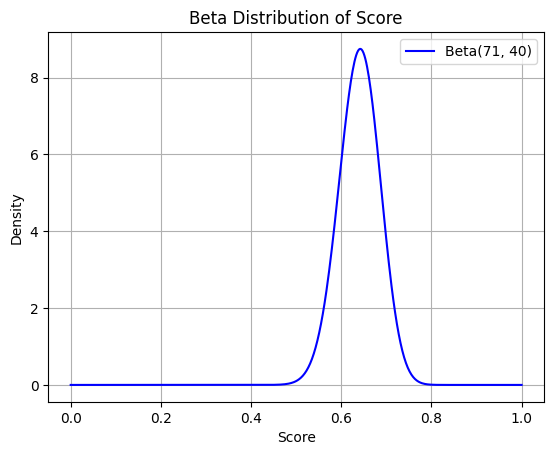

In [115]:
# Pull these from the RT website
positive_reviews = 70
total_reviews = 109

# Compute alpha and beta (with Laplace smoothing)
alpha_param = positive_reviews + 1
beta_param = total_reviews - positive_reviews + 1

# Plot the Beta PDF
x = np.linspace(0, 1, 500)
pdf = beta.pdf(x, alpha_param, beta_param)

plt.plot(x, pdf, label=f'Beta({alpha_param}, {beta_param})', color='blue')
plt.title("Beta Distribution of Score")
plt.xlabel("Score")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()

###### The simplest way to forecast future probabilities is to assume that future reviews are sampled from the current posterior distribution of the underlying score. Under this assumption, one can use either Monte Carlo sampling (constant_monte_carlo) or the analytical Beta-Binomial mixture (beta_binomial_pmf + final_score_pdf) for a given number of expected future reviews.

###### The mixture distribution combines a discrete distribution over the possible number of new positive reviews with a continuous Beta distribution representing the posterior uncertainty of the score for each scenario.

###### Integrating under the resulting mixture PDF yields the CDF, which can then be evaluated at the relevant thresholds to obtain probabilities.

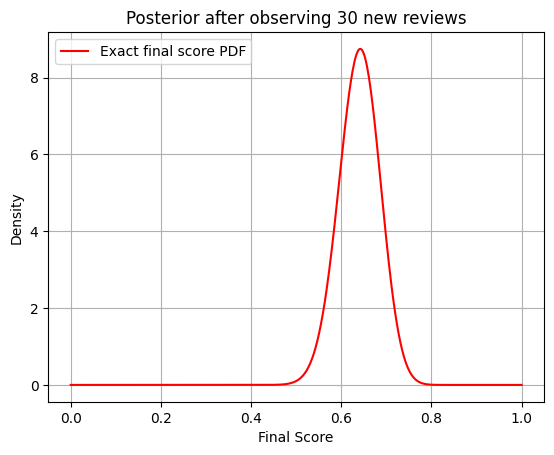

In [116]:
n_new = 30
# Evaluation points
x = np.linspace(0, 1, 500)
pdf = functions.final_score_pdf(x, alpha_param, beta_param, n_new)

plt.plot(x, pdf, label='Exact final score PDF', color='red')
plt.title(f'Posterior after observing {n_new} new reviews')
plt.xlabel('Final Score')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

P(final score ≤ 0.645) = 0.5395
Expected final score = 0.6396


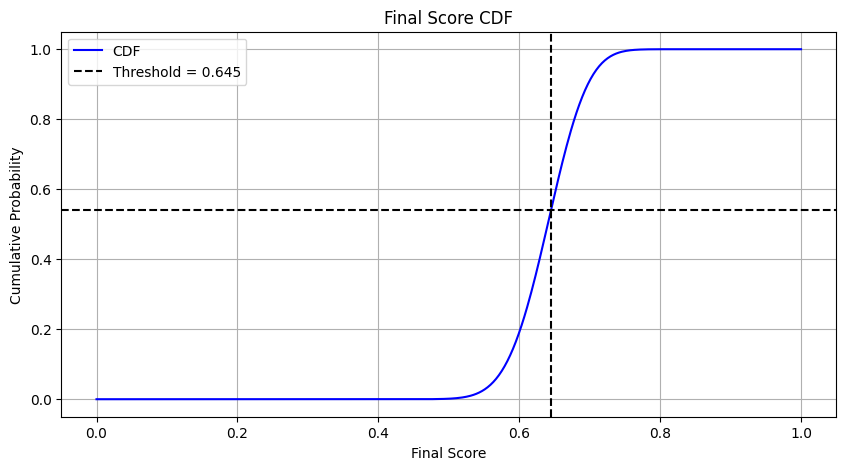

In [117]:
# --- Exact CDF using mixture_cdf ---
cdf = np.array([functions.mixture_cdf(xi, alpha_param, beta_param, n_new) for xi in x])

threshold = 0.645  # account for rounding
prob_left = functions.mixture_cdf(threshold, alpha_param, beta_param, n_new)
mean_score = functions.mixture_mean(alpha_param, beta_param, n_new)

print(f"P(final score ≤ {threshold:.3f}) = {prob_left:.4f}")
print(f"Expected final score = {mean_score:.4f}")

# --- Plot CDF ---
plt.figure(figsize=(10,5))
plt.plot(x, cdf, color='blue', label='CDF')
plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold:.3f}')
plt.axhline(prob_left, color='black', linestyle='--')
plt.title("Final Score CDF")
plt.xlabel("Final Score")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.legend()
plt.show()

###### Alternatively, you can make the assumption that the new reviews come from a conditionally updating distribution. 

###### For example if there were 5/10 positive reviews, the mean of the beta distribtion is 0.50. But if the next review was positive, then the mean would shift to 6/11 or 0.545 (and the α and β parameters would also shift accordingly).

###### We use run_beta_monte_carlo for this Bayesian updating assumption. This method yields a converging result total_reviews n_new reviews -> inf, but with lesser values of each, the Bayesian updating methods will have stronger drift based on the mean's distance above/below 0.5.

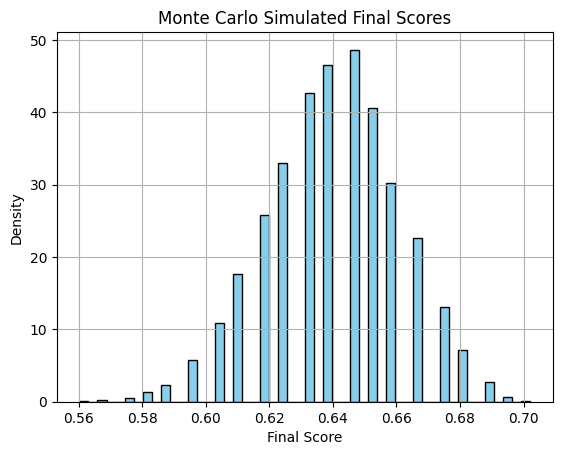

In [118]:
pos_reviews = 70
total_reviews = 109
n_new = 30

final_scores = functions.run_beta_monte_carlo(pos_reviews, total_reviews, n_new, num_simulations = 10000)
plt.hist(final_scores, bins=50, density=True, color="skyblue", edgecolor="black")
plt.title("Monte Carlo Simulated Final Scores")
plt.xlabel("Final Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

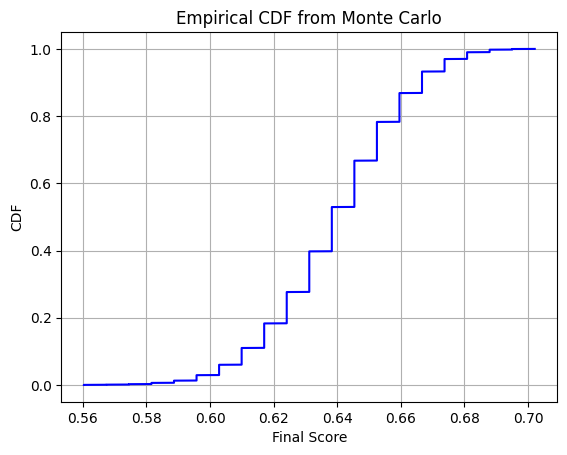

P(final score ≤ 0.645) ≈ 0.5294


In [119]:
sorted_scores = np.sort(final_scores)

# Empirical CDF values
cdf_values = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)


plt.plot(sorted_scores, cdf_values, color='blue')
plt.xlabel('Final Score')
plt.ylabel('CDF')
plt.title('Empirical CDF from Monte Carlo')
plt.grid(True)
plt.show()

threshold = 0.645
prob_left = np.mean(final_scores <= threshold)
print(f"P(final score ≤ {threshold}) ≈ {prob_left:.4f}")


###### The above models procured a small edge that was greatly improved upon when I started accounting for an empirical feature - decay. 

###### If a critic is early to review a movie, they are most likely relatively more enthusiastic about it and will thus rate it higher. Also, production companies may not give certain critics early access to the film if they are unlikely to review it well. Such reviews won't come in until after the premiere. This gives reason to believe that movie ratings will decay over time. 

###### We can model this as if the more recent reviews come from a different beta distribution using either biased_trend_monte_carlo or the more technical trend_weighted_monte_carlo

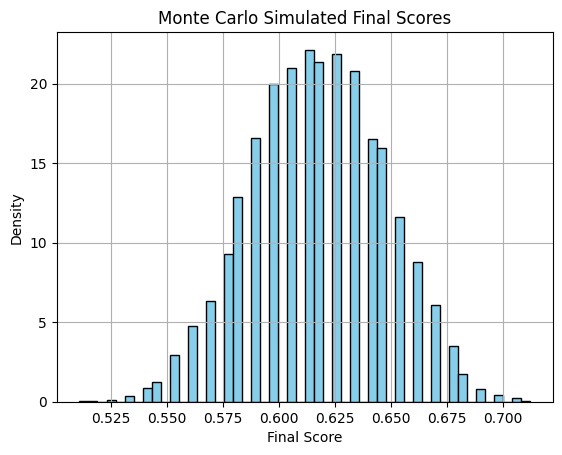

In [120]:

historical_pos = 70
historical_total = 109
recent_pos = 10
recent_total = 19
future_reviews = 30
final_scores = functions.biased_trend_monte_carlo(historical_pos, historical_total, recent_pos, recent_total, future_reviews = 30, num_simulations = 10000)

plt.hist(final_scores, bins=50, density=True, color="skyblue", edgecolor="black")
plt.title("Monte Carlo Simulated Final Scores")
plt.xlabel("Final Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

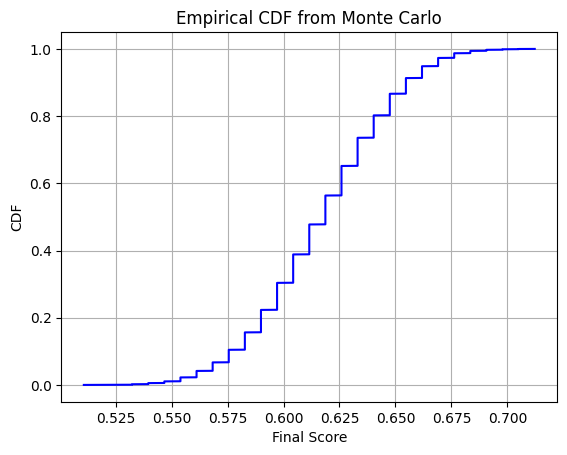

P(final score ≤ 0.645) ≈ 0.8022


In [121]:
sorted_scores = np.sort(final_scores)

# Empirical CDF values
cdf_values = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)


plt.plot(sorted_scores, cdf_values, color='blue')
plt.xlabel('Final Score')
plt.ylabel('CDF')
plt.title('Empirical CDF from Monte Carlo')
plt.grid(True)
plt.show()

threshold = 0.645
prob_left = np.mean(final_scores <= threshold)
print(f"P(final score ≤ {threshold}) ≈ {prob_left:.4f}")

###### In sum this notebook leaves a series of models from which you can use to discretionarily trade a movie's Rotten Tomatoes Score on Kalshi. 

###### This could all be automated by combining the RT Scraper, Kalshi API, and ensembling/selecting the models, however there are too many variables and infrequencies such that no two movies are the same. Embargo dates, RT score updates, final review count, and score are wildly inconsistent and create a difficult space to reliably systematically trade. My success in these events came from using the models as tools in the discretionary process, not as algorithms.

###### I have additional private files concerning the backtesting process and automation, as well as some ML implementations I experimented with. The monetary gain from the strategies are nothing substantial because of the infrequency of events and high variance nature of digital options. I’m sharing these files to showcase a project I genuinely enjoyed working on. For any questions or further discussion on this project, feel free to reach out at ase9pz@virginia.edu

